# Study of Automated Shuttle Interactions in City Traffic Using Surrogate Measures of Safety

## Author
Étienne Beauchamp  
M.A.Sc. candidate, Department of Civil, Geological and Mining Engineering  
Polytechnique Montréal, C.P. 6079, succ. Centre-Ville  
Montréal (Québec) Canada H3C 3A7  
Phone: (514) 340-4711 ext. 4210  
Email: etienne-2.beauchamp@polymtl.ca

## Overview
This code was written as part of a research study. It uses methods from the TrafficIntelligence Python module to analyze data extracted from video recordings.

Before getting started, you will need to install the following:
* Python 3 (3.7.3 was used here);
* [Pandas](https://pandas.pydata.org/);
* [Matplotlib](https://matplotlib.org/);
* [Statsmodels](https://www.statsmodels.org/).

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from distutils import util
from scipy import stats

In [2]:
pd.set_option('display.max_columns', None)  # Show all columns in dataframe when displayed
sns.set()

## Speed and Acceleration

In [3]:
speedAcc = pd.read_csv("../data/speed-acceleration.csv")

In [4]:
speedAcc = speedAcc[speedAcc['av'].notnull()]
speedAcc.av = speedAcc.av.astype(int)
# speedAcc = speedAcc.loc[(speedAcc.av  == 0) | (speedAcc.av == 1)]  # analyzing only interactions with AV or control vehicles

In [5]:
speedAcc.head()

,Unnamed: 0,intersection,time,dbName,num,speed,acc,av
24,24,letourneux-coubertin,2019-07-03T10:30,2019-07-03T10:26-04:00.sqlite,86,7.682097,0.020747,1
131,131,letourneux-coubertin,2019-07-03T10:51,2019-07-03T10:46-04:00.sqlite,81,6.784812,-0.007110,1
133,133,letourneux-coubertin,2019-07-03T10:52,2019-07-03T10:46-04:00.sqlite,87,4.140178,0.006168,1
144,144,letourneux-coubertin,2019-07-03T10:54,2019-07-03T10:46-04:00.sqlite,117,36.893121,-1.661836,0
179,179,letourneux-coubertin,2019-07-03T10:59,2019-07-03T10:46-04:00.sqlite,219,8.786557,0.032888,1


In [6]:
speedAcc.intersection.unique()

array(['letourneux-coubertin', 'letourneux-hochelaga',
       'letourneux-ontario', 'montcalm-chartwell', 'montcalm-inverness',
       'montcalm-victorin', 'montcalm-voie'], dtype=object)

### Violin plot

In [7]:
def addNumberOfObservations(medians, nobs, xOffsetDivide, yOffset):
    # Execute for each subplot
    for ax in plt.gcf().axes:
        # Iterate through all the labels
        for tick, label in enumerate(ax.get_xticklabels()):
            # Retrieve x label (intersection name)
            axIntersection = label.get_text()
            for j, axLeadingUserType in enumerate(ax.get_legend_handles_labels()[1]):
                # Offset to the left or right of the split for each distribution (+- 0.0769)
                xOffset = (j - 0.5) * 2/xOffsetDivide
                # Get median and number of observations
                try:
                    medVal = medians[axIntersection, util.strtobool(axLeadingUserType)]
                    medVal = medians.at[axIntersection].at[util.strtobool(axLeadingUserType)]
                    num = nobs.at[axIntersection].at[util.strtobool(axLeadingUserType)]
                    # Add white text with the information
                    ax.text(tick + xOffset, medVal + yOffset, num, horizontalalignment="center", size="x-small", color="black", weight="semibold")
                except KeyError:
                    print("No observations")

def violinPlot(df, fileName, yLabelName, yMin, yMax):
    plt.figure(figsize=(16, 8))
    plt.ylim(yMin, yMax)
    ax = sns.violinplot(x="intersection", y=yLabelName, hue="av", data=df, split=True, inner="quartile", cut=0)
    
    # Number of observations for each distribution
    medians = df.groupby(["intersection", "av"])[yLabelName].median()
    nobs = df.groupby(["intersection", "av"]).count()[yLabelName].apply(lambda x: "n: {}".format(x))
    
    # Retrive all medians and numbers for each intersection to write to plot
    if yLabelName == "speed":
        yLabelName = "Mean speed (km/h)"
        yOffset = 0.1
    elif yLabelName == "acc":
        yLabelName = "Mean acceleration ($m/s^2$)"
        yOffset = 0.1
        
    addNumberOfObservations(medians, nobs, 9, yOffset)
    
    # Set legend
    handles, labels = ax.figure.get_axes()[0].get_legend_handles_labels()
    ax.figure.get_axes()[0].legend([handles[0], handles[1]], ["control", "AV"], loc="upper left")
    ax.set(xlabel='Intersection', ylabel=yLabelName)
    
    plt.savefig("../imgs/" + fileName + ".pdf", format="pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    
def ksTest(df, yLabelName):
    tableSite = " "
    tableD = "D (k-s statitic)"
    tableP = "p-value"

    locations = ["letourneux-coubertin", "letourneux-hochelaga", "letourneux-ontario", "montcalm-chartwell", 
                 "montcalm-inverness", "montcalm-victorin", "montcalm-voie"]
    
    # K-S test for all intersections
    for intersection in locations:
        # isolate distribution for AV and control vehicles
        dist1 = df.loc[(df.av == 1) & (df.intersection == intersection)]
        dist2 = df.loc[(df.av == 0) & (df.intersection == intersection)]
        D_statistic, p_value = stats.ks_2samp(dist1[yLabelName], dist2[yLabelName])
        # Add values to table
        tableSite += " & {}".format(intersection)
        tableD += " & {:.4}".format(D_statistic)
        tableP += " & {:.4}".format(p_value) 

    print(tableSite + " \\\ \hline \n" + tableD + " \\\ \hline \n" + tableP + " \\\ \hline")

#### Speed distributions

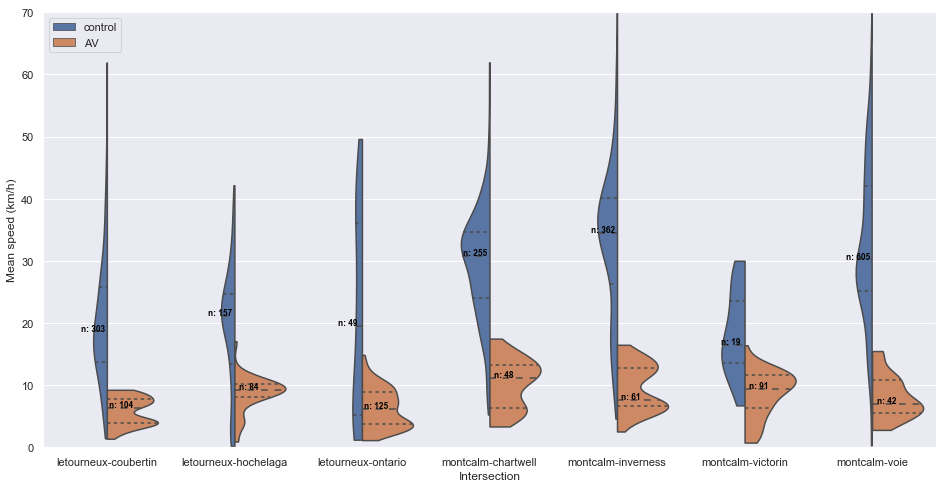

In [8]:
violinPlot(speedAcc, "speed_av_vs_similar", "speed", 0, 70)

##### Kolmogorov–Smirnov test

In [9]:
ksTest(speedAcc, "speed")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.8845 & 0.7541 & 0.5634 & 0.9137 & 0.8814 & 0.7981 & 0.9107 \\ \hline 
p-value & 1.332e-15 & 0.0 & 6.662e-11 & 7.772e-16 & 2.22e-16 & 7.563e-11 & 1.11e-15 \\ \hline


#### Acceleration distributions

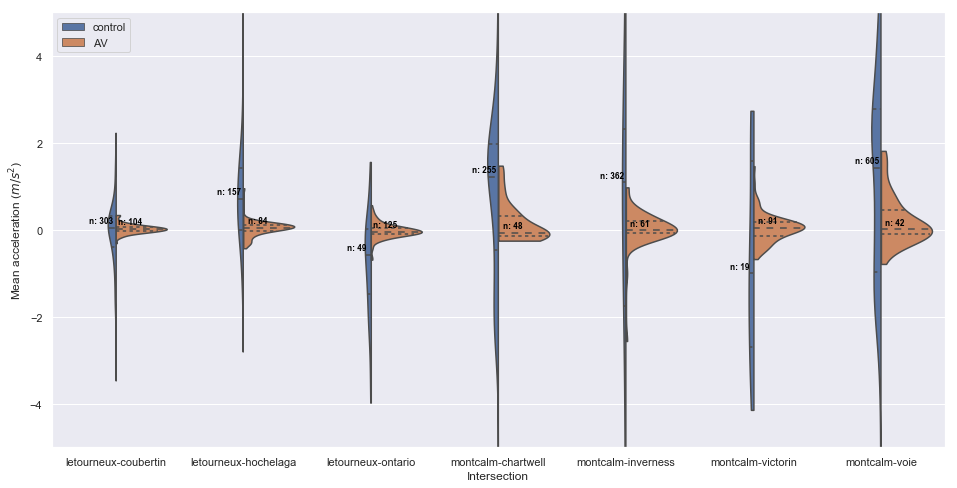

In [10]:
violinPlot(speedAcc, "acceleration_av_vs_similar", "acc", -5, 5)

##### Kolmogorov–Smirnov test

In [11]:
ksTest(speedAcc, "acc")

  & letourneux-coubertin & letourneux-hochelaga & letourneux-ontario & montcalm-chartwell & montcalm-inverness & montcalm-victorin & montcalm-voie \\ \hline 
D (k-s statitic) & 0.3405 & 0.6777 & 0.5722 & 0.5221 & 0.5197 & 0.546 & 0.4542 \\ \hline 
p-value & 1.707e-08 & 0.0 & 2.924e-11 & 1.127e-10 & 1.511e-13 & 6.654e-05 & 6.598e-08 \\ \hline
